## Machine Learning with Persistence Images

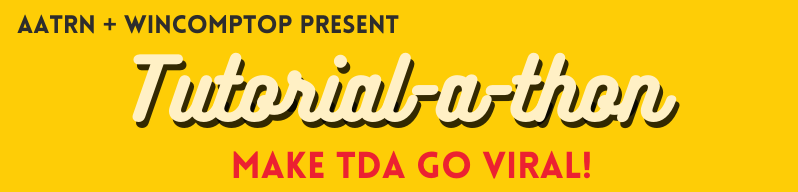

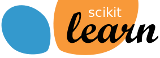

https://sites.google.com/view/aatrn-tutorial-a-thon

https://www.youtube.com/playlist?list=PL4kY-dS_mSmJabQiM2ySRSUusbvmdIxBt

https://giotto-ai.github.io/gtda-docs/

https://scikit-learn.org/

In this notebook we're going to try and classify between hand-drawn 0s and 8s using their $H_1$ persistence.

### Load some MNIST data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

We load up the MNIST hand-drawn digits dataset and throw away everything that isn't a 0 or an 8.

In [2]:
digits = datasets.load_digits()
indices = (digits.target == 0) | (digits.target == 8)
y = digits.target[indices]
X = digits.data[indices].reshape([sum(indices), 8, 8])

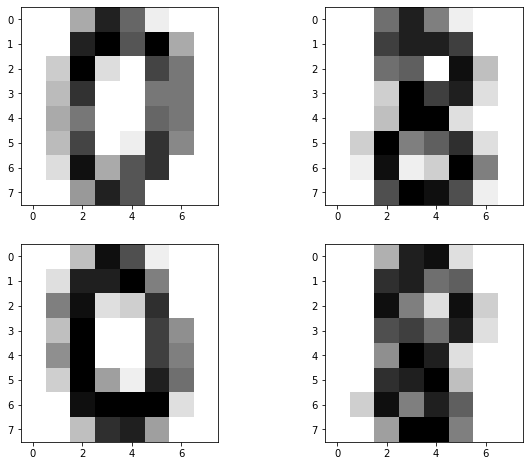

In [3]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(X[0], cmap='gray_r')
plt.subplot(2,2,2)
_=plt.imshow(X[1], cmap='gray_r')
plt.subplot(2,2,3)
plt.imshow(X[40], cmap='gray_r')
plt.subplot(2,2,4)
_=plt.imshow(X[51], cmap='gray_r')

### Prepare the data and produce persistence images

We want to encode some location information into the pixels so that we will be able to distinguish the holes in the 8s, so we multiply each pixel (x,y) by $1 + \frac{1}{2} y$.

In [4]:
dists = 1 + 0.5 * np.array([[ y for x in range(8) ] for y in range(8)])

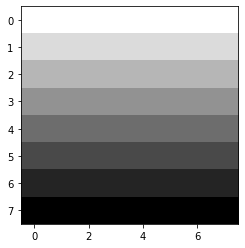

In [5]:
_=plt.imshow(dists, cmap='gray_r')

In [6]:
X_1 = X * dists[np.newaxis,:,:]

Looking at the resulting images, we see now that if we filter our images from dark pixels to light we will see the hole in the 0 and the top hole in the 8 appearing late and dying when the white pixels are added, and the bottom hole in the 8 appearing early and dying much later.

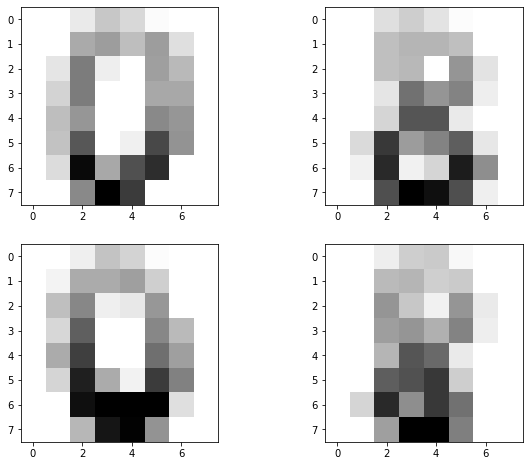

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(X_1[0], cmap='gray_r')
plt.subplot(2,2,2)
_=plt.imshow(X_1[1], cmap='gray_r')
plt.subplot(2,2,3)
plt.imshow(X_1[40], cmap='gray_r')
plt.subplot(2,2,4)
_=plt.imshow(X_1[51], cmap='gray_r')

Persistent cubical homology is appropriate here for image data that naturally forms a cubical complex.

In [8]:
from gtda.homology import CubicalPersistence

In [9]:
cp = CubicalPersistence(homology_dimensions=[1], coeff=2, periodic_dimensions=None)

persistence = cp.fit_transform(-X_1)

We use a function from Gudhi rather than Giotto to plot our persistence images since it plays nicer with matplotlib, although it requires a bit of conversion between the diagram formats.

In [10]:
from gudhi.persistence_graphical_tools import plot_persistence_diagram

Plotting the persistence diagrams we see that they capture the holes as expected.

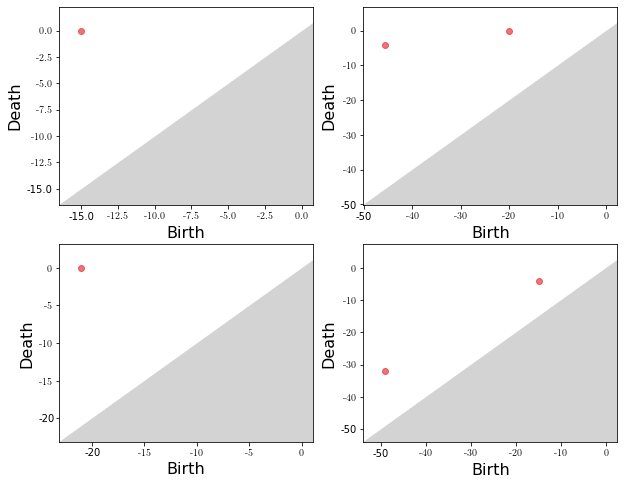

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
plot_persistence_diagram(persistence[0][persistence[0,:,0] != persistence[0,:,1]][:,[0,1]], axes=axs[0][0])
plot_persistence_diagram(persistence[1][persistence[1,:,0] != persistence[1,:,1]][:,[0,1]], axes=axs[0][1])
plot_persistence_diagram(persistence[40][persistence[40,:,0] != persistence[40,:,1]][:,[0,1]], axes=axs[1][0])
plot_persistence_diagram(persistence[51][persistence[51,:,0] != persistence[51,:,1]][:,[0,1]], axes=axs[1][1])
_=[[a.set_title("") for a in ax] for ax in axs]

Now we compute the persistence images with a 15x15 resolution and Gaussians of standard deviation 1.

In [12]:
from gtda.diagrams import PersistenceImage

In [13]:
pi_res = 15
sigma = 1
pi = PersistenceImage(sigma=sigma, n_bins=pi_res, weight_function=None)

persistence_images = pi.fit_transform(persistence)[:,0]

extent = [min(pi.samplings_[1][0]), max(pi.samplings_[1][0]), min(pi.samplings_[1][1]), max(pi.samplings_[1][1])]

Taking a look at the average persistence image for the 0s and for the 8s, we see one cluster for the 0s and two for the 8s as expected.

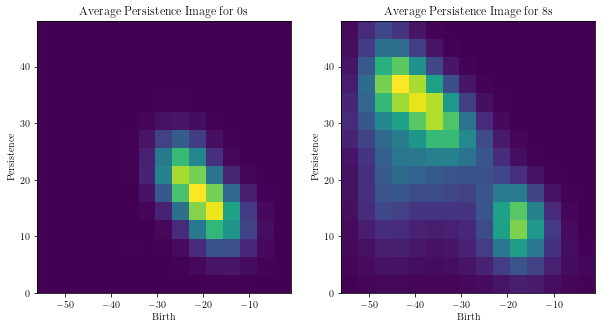

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.mean(persistence_images[y == 0], axis=0), aspect='auto', extent=extent)
plt.xlabel("Birth")
plt.ylabel("Persistence")
plt.title("Average Persistence Image for 0s")
plt.subplot(1,2,2)
plt.imshow(np.mean(persistence_images[y == 8], axis=0), aspect='auto', extent=extent)
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Average Persistence Image for 8s")

### Do some machine learning to classify 0s and 8s from the persistence images

Split our data up into a training set and a test set: we'll train our models on the training set and see how well they generalise to the test set.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    persistence_images.reshape(len(y), pi_res**2), y, test_size=0.3, random_state=2)

#### Support Vector Machine classification

Let's try SVM which tries to find the maximum-margin hyperplane seperating our data.

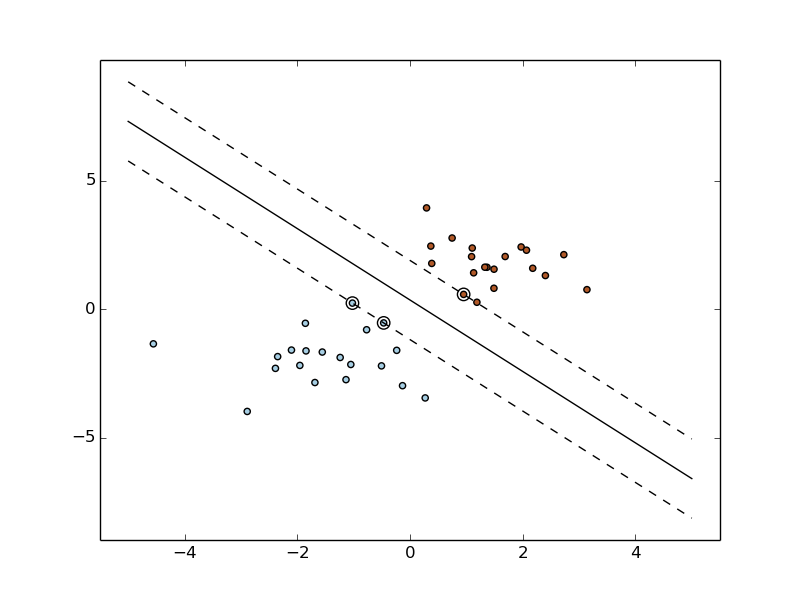

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [18]:
clf = make_pipeline(StandardScaler(), 
                    SVC(kernel='linear')).fit(X_train, y_train)

It does pretty well: 95% accuracy! But we see that the coefficients it learns are pretty hard to interpret.

Accuracy: 0.95283018


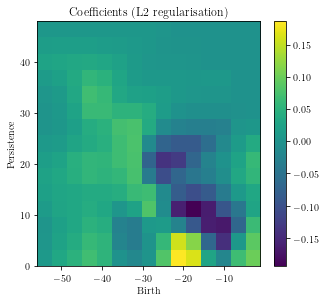

In [19]:
print("Accuracy: " + str(clf.score(X_test, y_test))[:10])
plt.figure(figsize=(5,4.5))
plt.imshow(clf.steps[1][1].coef_.reshape([pi_res, pi_res]), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Coefficients (L2 regularisation)")

#### Logistic Regression for interpretable classification

For more interpretable results we use logistic regression, which we can use since persistence images are vectors. It computes a sigmoid function on a linear combination of the persistence image pixels to classify the data. We use L2 regularisation for the weights to promote good generalisation.

In [20]:
from sklearn.linear_model import LogisticRegression

$p(\text{$x$ comes from an 8}) = (1 + exp(w_1x_1 + \dots + w_Nx_N))^{-1}$

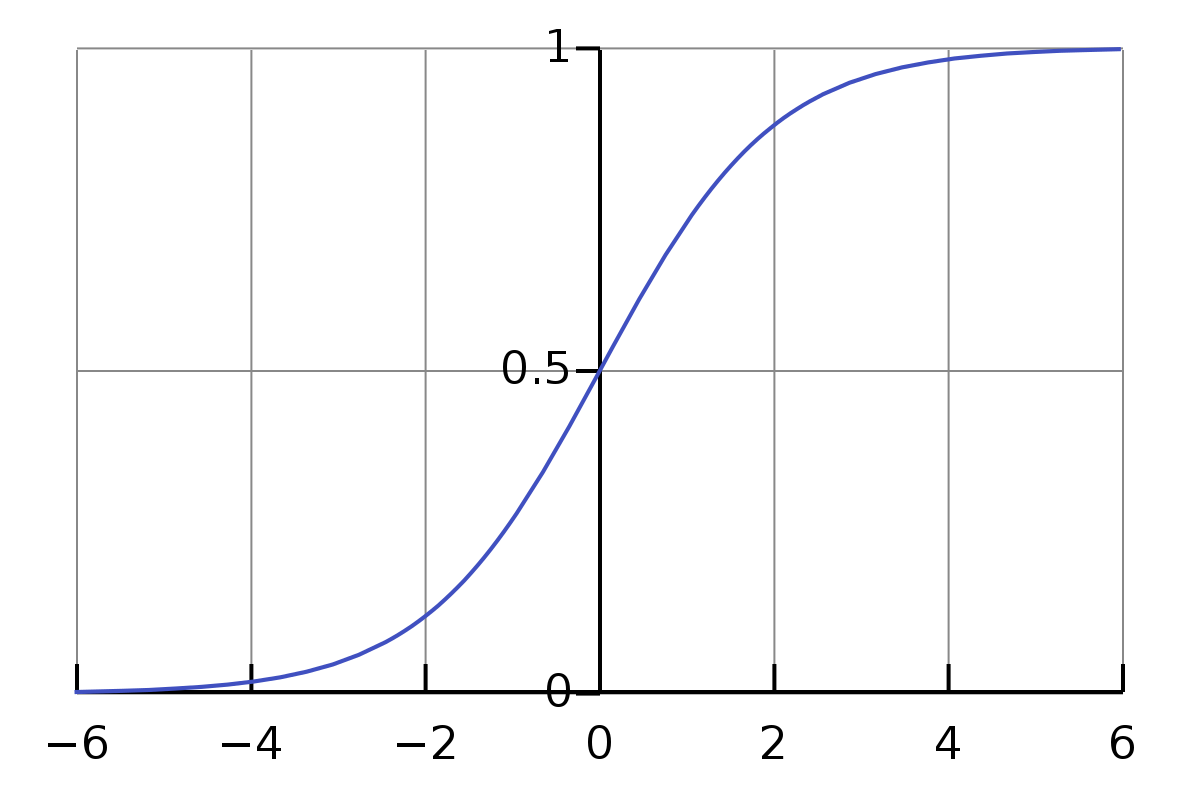

In [21]:
clf = LogisticRegression(fit_intercept=False, penalty='l2').fit(X_train, y_train)

$min_w \big[ \text{incorrect classification} + (w_1^2 + \dots + w_N^2) \big]$

It's not as accurate, but the learned weights are much more easily interpretable. In fact, we can directly compare them with the average persistence images for the 0s and for the 8s.

Accuracy: 0.83962264


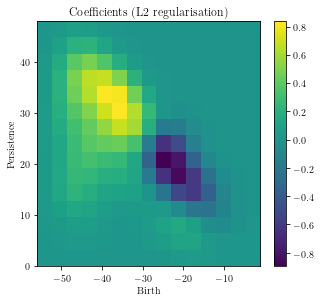

In [22]:
print("Accuracy: " + str(clf.score(X_test, y_test))[:10])
plt.figure(figsize=(5,4.5))
plt.imshow(clf.coef_.reshape([pi_res, pi_res]), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Coefficients (L2 regularisation)")

In [23]:
from sklearn.metrics import plot_confusion_matrix

A confusion matrix shows us where the model goes wrong. Here we see that the 0s are all correctly classified, but quite a few of the 8s are being confused for 0s.

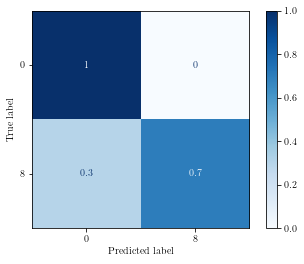

In [24]:
_=plot_confusion_matrix(clf, X_test, y_test, display_labels=["0", "8"],
                      cmap=plt.cm.Blues, normalize='true')

#### Logistic Regression with L1 regularisation to find most important components

We got a nice picture from the coefficients using L2 regularisation, but using L1 will help us find the most important components.

In [25]:
clf = LogisticRegression(fit_intercept=False, penalty='l1', solver='liblinear', C=1).fit(X_train, y_train)

$min_w \big[ \text{incorrect classification} + (\vert w_1 \vert + \dots + \vert w_N \vert) \big]$

Accuracy: 0.70754716


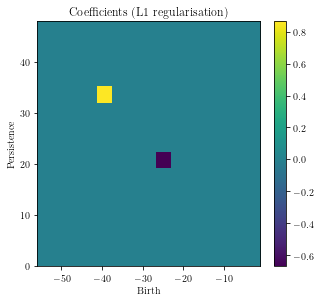

In [26]:
print("Accuracy: " + str(clf.score(X_test, y_test))[:10])
plt.figure(figsize=(5,4.5))
plt.imshow(clf.coef_.reshape([pi_res, pi_res]), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Coefficients (L1 regularisation)")

### All digits

Finally we try out the method on all the digits 0-9. We don't expect this to go well, but it may be interesting to see where it fails.

In [27]:
y_all = digits.target
X_all = digits.data.reshape([len(y_all), 8, 8])

In [28]:
X_1_all = X_all * dists[np.newaxis,:,:]
persistence_all = cp.fit_transform(-X_1_all)
persistence_images_all = pi.fit_transform(persistence_all)[:,0]

We see that the average persistence images for many of the digits look very similar.

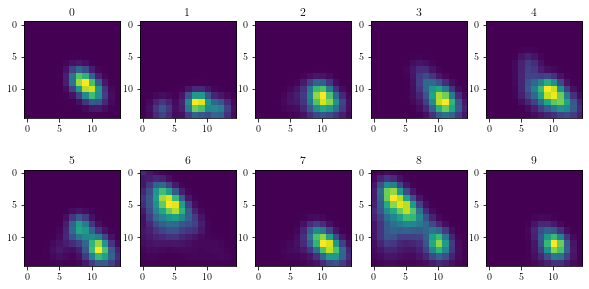

In [29]:
plt.figure(figsize=(10,5))
for yval in range(0,10):
    plt.subplot(2,5,yval+1)
    plt.imshow(np.mean(persistence_images_all[y_all == yval], axis=0).reshape([pi_res, pi_res]))
    plt.title(str(yval))

In [30]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    persistence_images_all.reshape(len(y_all), pi_res**2), y_all, test_size=0.3, random_state=5)

The confusion matrix shows us that all the digits with holes (0, 6, 8, 9) do well for themselves, while those that don't all get misclassified as a 1. The $H_1$ persistence just sees a shape with no holes. There's also some interesting confusion between 6s and 8s which could easily look like each other if drawn in a hurry.

Accuracy: 0.37962962


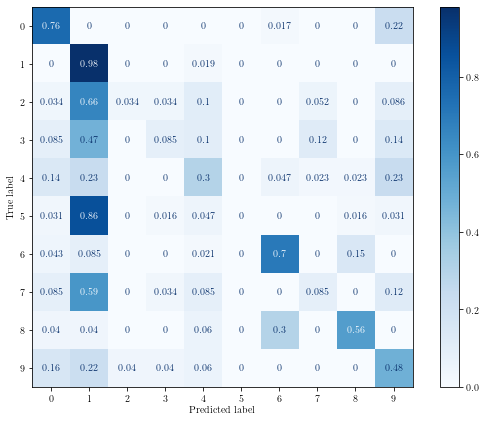

In [31]:
clf = make_pipeline(StandardScaler(), SVC(kernel='linear')).fit(X_all_train, y_all_train)
print("Accuracy: " + str(clf.score(X_all_test, y_all_test))[:10])
_=plt.figure(figsize=(10,7))
ax = plt.axes()
_=plot_confusion_matrix(clf, X_all_test, y_all_test, display_labels=[str(i) for i in range(10)],
                      cmap=plt.cm.Blues, normalize='true', ax=ax)